# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

### Recomendación: usar matplotlib, wfdb, scipy.io

In [4]:
# Define una función reutilizable para cargar y plotear un segmento ECG


def plot_ecg_segment(data_dir):
  
    import os
    import scipy.io as sio
    import matplotlib.pyplot as plt
    import numpy as np

     # Buscamos archivos .mat y tomamos sólo el primero
    mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])
    if not mat_files:
        raise FileNotFoundError(f"No se encontraron .mat en {data_dir}")
    file0 = mat_files[0]

    # Cargamos la señal
    mat = sio.loadmat(os.path.join(data_dir, file0))
    if 'val' in mat:
        signal = mat['val']
    elif 'ECG' in mat:
        signal = mat['ECG']
    else:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    signal = signal.flatten()

    # Parámetros internos fijos
    fs = 300            # Hz
    duration = 10       # segundos

    # Tomamos los primeros 10 s
    n_samples = min(len(signal), fs*duration)
    time = np.arange(n_samples) / fs
    segment = signal[:n_samples]


    plt.figure(figsize=(12,4))
    plt.plot(time, segment, lw=0.8)
    plt.title(f"ECG – {file0} ({duration} s)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.show()

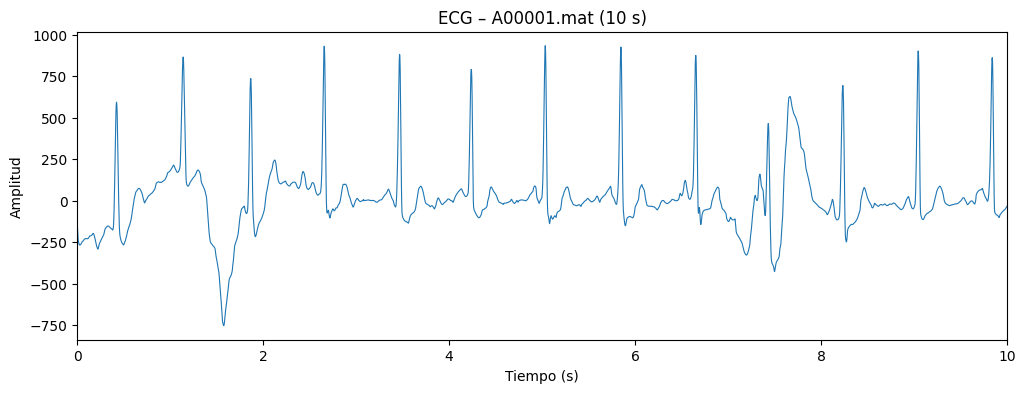

In [5]:
from pathlib import Path

# ./training2017
data_dir = Path("../data/training2017")
plot_ecg_segment(data_dir)

In [ ]:
# celda c25c5bf8: instalaciones
#%pip install wfdb scipy pandas matplotlib neurokit2 PyWavelets

import os
from pathlib import Path
from wfdb import rdrecord
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# ahora NeuroKit2 con PyWavelets disponible
import neurokit2 as nk

# Directorio de registros y etiquetas
data_dir = Path("../data/training2017")
ref = pd.read_csv(os.path.join(data_dir, "REFERENCE.csv"),
                  header=None, names=['registro','label'])
label_map = {'N':'Normal', 'A':'AFib'}
ref['label'] = ref['label'].map(label_map).fillna('Other')
ref_dict = ref.set_index('registro')['label'].to_dict()

# Listado y muestreo de archivos
records = []
fs_target = 300
max_duration = 10  # segundos
for fname in sorted(f for f in os.listdir(data_dir) if f.endswith('.mat'))[:60]:
    mat_contents = sio.loadmat(os.path.join(data_dir, fname))
    if 'val' in mat_contents:
        sig = mat_contents['val'].flatten()
    elif 'ECG' in mat_contents:
        sig = mat_contents['ECG'].flatten()
    else:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    fs = fs_target  # usamos fs_target=300
    n_samples = min(len(sig), fs*max_duration)
    segment = sig[:n_samples]
    duration_seq = n_samples / fs

    # Estadísticas de amplitud
    media_mv = segment.mean()
    mstd_mV = segment.std()
    skewness = skew(segment)
    kurt_val = kurtosis(segment)

    # RR intervals (reemplaza el bloque con find_peaks)
    signals, info = nk.ecg_peaks(segment, sampling_rate=fs)
    rpeaks      = info["ECG_R_Peaks"]
    rr          = np.diff(rpeaks) / fs if len(rpeaks)>1 else np.array([])
    rr_mean_s   = rr.mean() if rr.size>0 else np.nan
    rr_std_s    = rr.std()  if rr.size>0 else np.nan

    # Clase
    label = ref_dict.get(rec_name, 'Unknown')

    records.append({
        'registro':     rec_name,
        'label':        label,
        'fs':           fs,
        'duracion_seq': duration_seq,
        'media_mv':     media_mv,
        'mstd_mV':      mstd_mV,
        'skewness':     skewness,
        'kurtosis':     kurt_val,
        'rr_mean_s':    rr_mean_s,
        'rr_std_s':     rr_std_s
    })

# Guardar CSV
df = pd.DataFrame(records)
out_csv = Path("../data/ecg_features.csv")
df.to_csv(out_csv, index=False)
print("Total registros:", df.shape[0])
print("Recuento por clase:")
print(df['label'].value_counts())


HeaderSyntaxError: invalid syntax in record line

In [3]:
# Celda de “## 2. Inspección básica del dataset” (id: e02aa7d6)
from pathlib import Path
import pandas as pd

csv_path = Path("../data/ecg_features.csv")
df = pd.read_csv(csv_path)

# Mostrar más filas en la vista previa
display(df.head(10))           # ver primeras 50 filas (antes sólo usabas head())
print("Total filas:", df.shape[0])

,Unnamed: 0


Total filas: 0


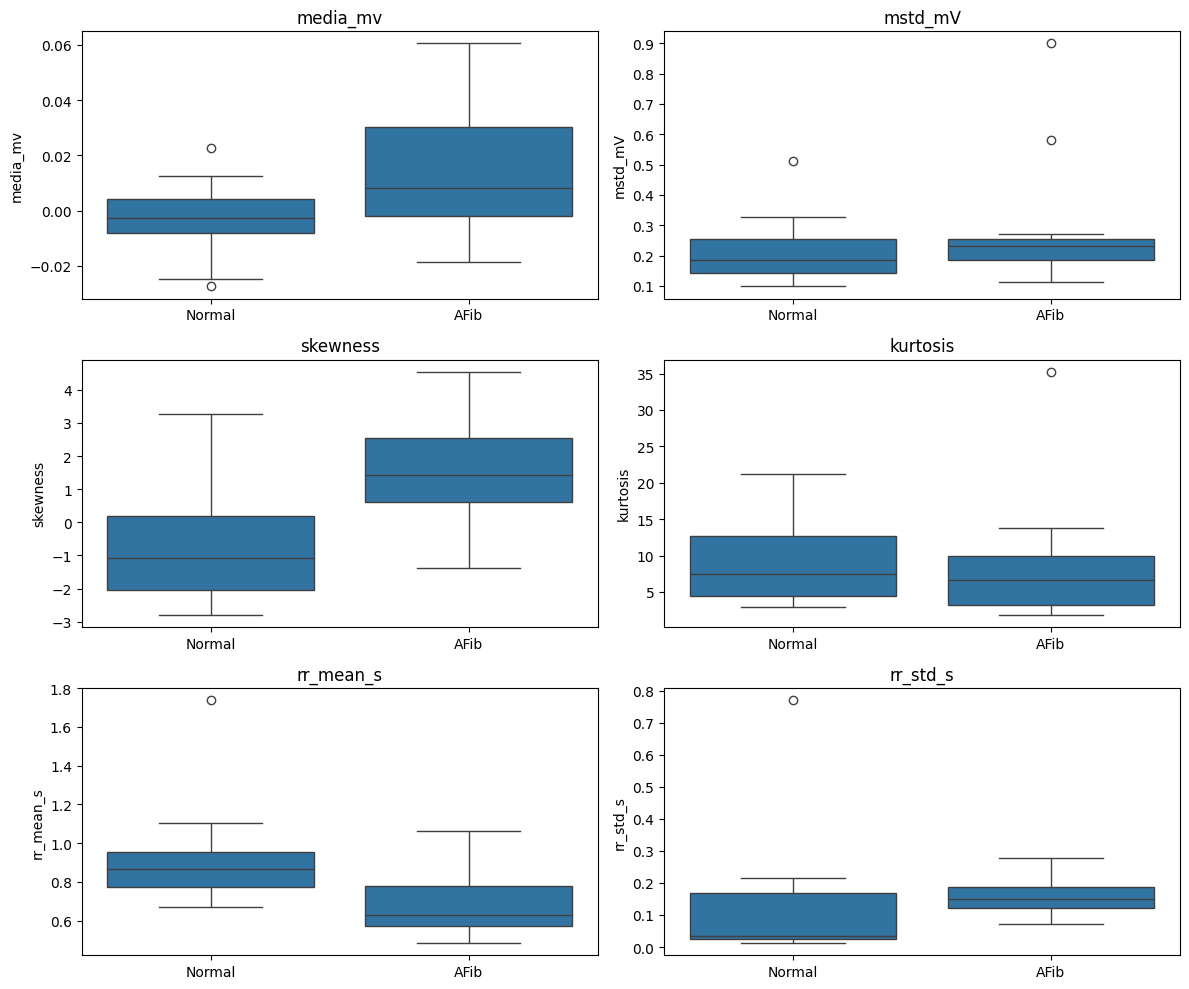

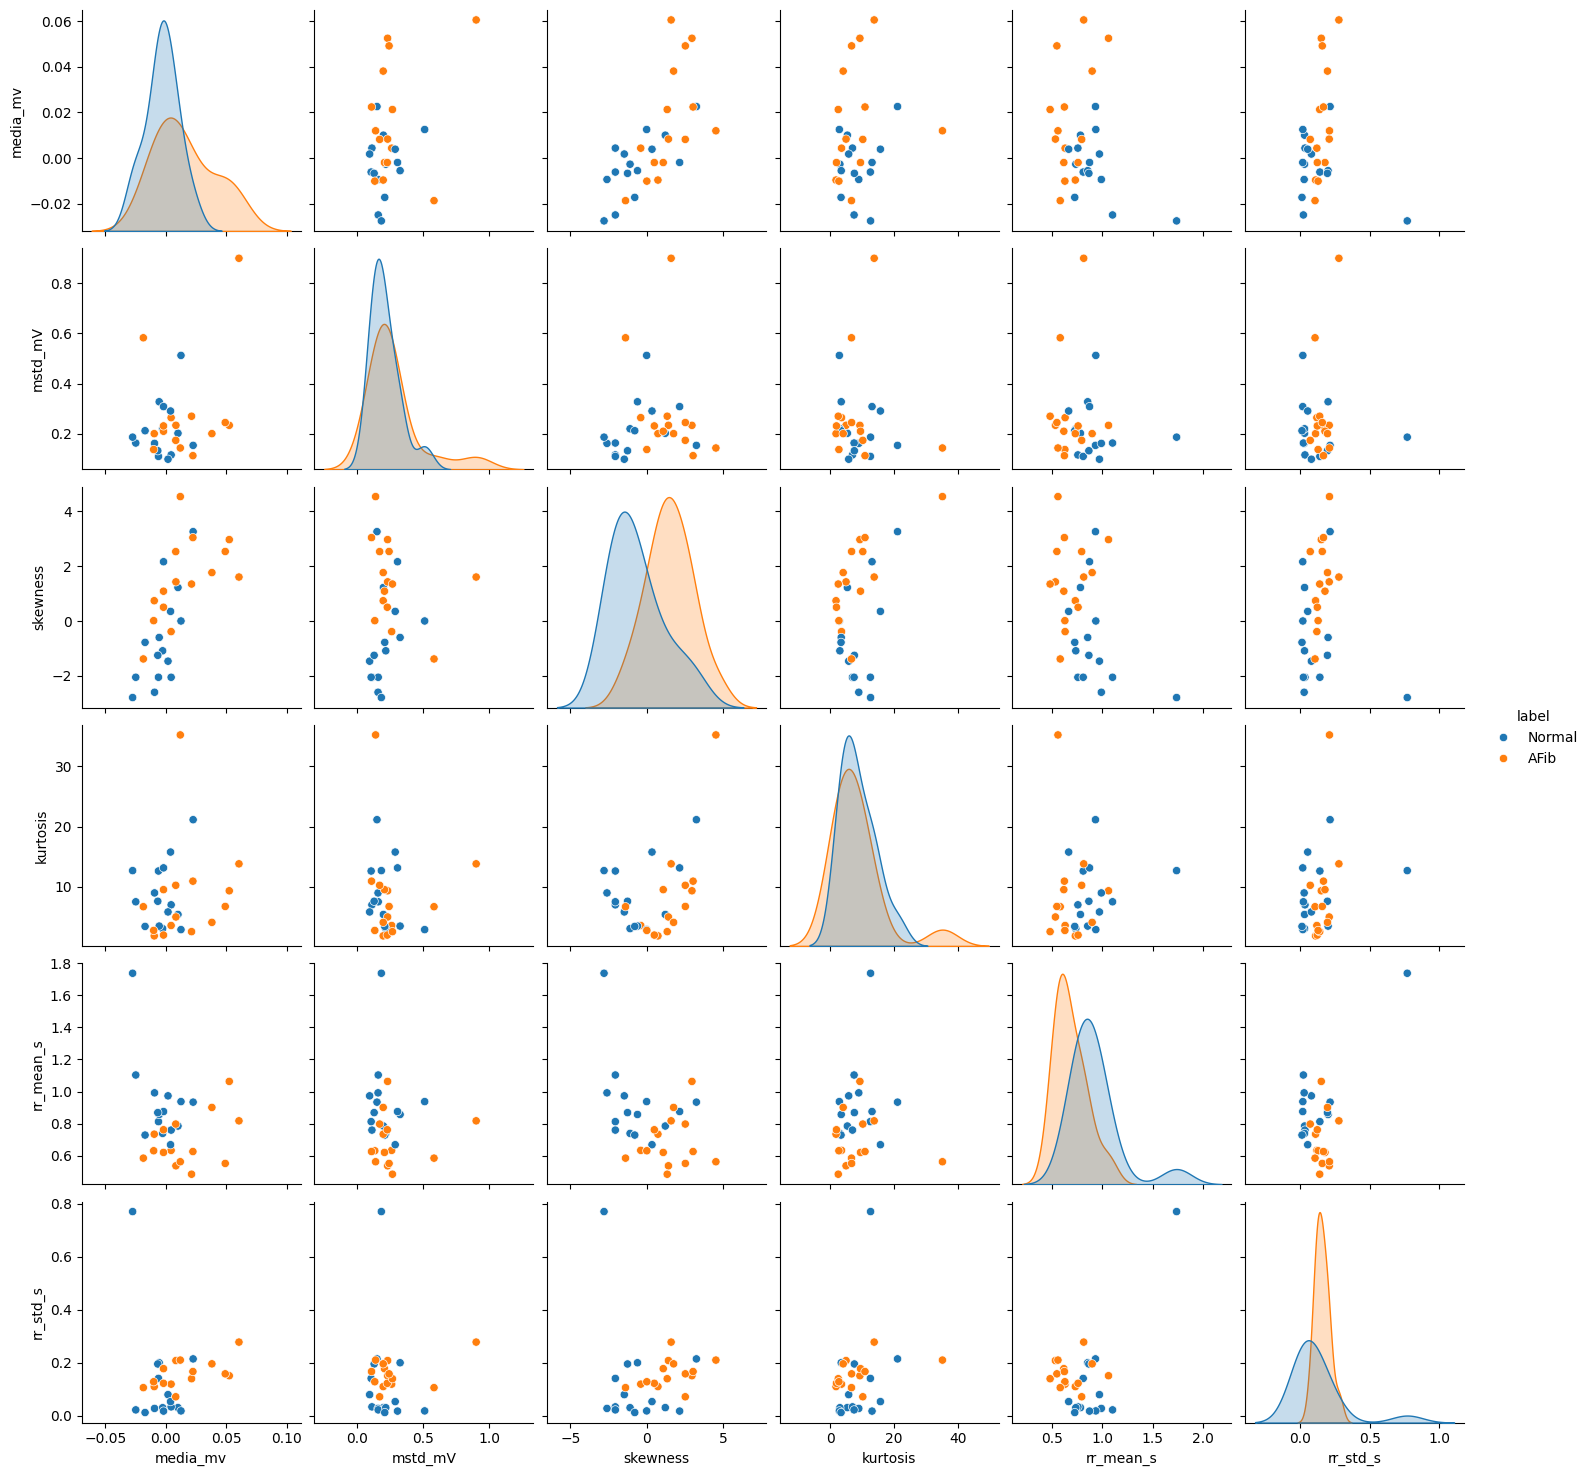

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Visualización de distribuciones por clase
features = ['media_mv','mstd_mV','skewness','kurtosis','rr_mean_s','rr_std_s']

# Boxplots
fig, axes = plt.subplots(3, 2, figsize=(12,10))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x='label', y=feat, data=df, ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(df, vars=features, hue='label', diag_kind='kde', height=2.5)
plt.show()

**Conlusiones**

1. ¿Qué variables parecen diferenciar más entre clases?

- skewness: los valores de asimetría para AFib están claramente desplazados hacia la derecha (positivos), mientras que los normales tienden a ser negativos.
- rr_std_s: la desviación de los intervalos RR es notablemente mayor en AFib.

- mstd_mV: la dispersión de la señal (desviación estándar) es ligeramente superior en AFib.

- rr_mean_s: la media de los intervalos RR tiende a ser algo menor en AFib, aunque con cierto solapamiento.

2. ¿Qué aspectos del dataset llaman la atención?  
- Hay bastante solapamiento en algunas métricas (por ejemplo, rr_mean_s y media_mv), lo que dificulta una separación perfecta.
- Existen outliers marcados, sobre todo en kurtosis y en algunos casos de mstd_mV.
- El tamaño (30 registros) es reducido; convendría ampliar el conjunto para validar estas tendencias con mayor robustez.
